# Dog Breed Classification

## Objective

The objective of this project is to use a machine learning model to come up with a solution that classifies an image of a dog based on dog breeds. This solution can be used to predict a dog's breed and to find possible breeds that can be found in a mixed-bred dog. 

## How should Performance be measured?

For this solution, neural network models from TensorFlow Keras will be utilized, and the method of determining and measuring performance will be with accuracy and top k categorical accuracy. Accuracy will be how accurate it is at predicting a dog's breed and the top k categorical accuracy is how good the model is at determining and predicting the best top breeds that match the image of the dog. Top k categorical accuracy is necessary to determine several possible breeds that can be found in a mixed-breed dog. 

# Obtain and Examine data

For this solution, I will be using the TensorFlow dataset named the Stanford Dogs Dataset. The documentation for the dataset can be found here: http://vision.stanford.edu/aditya86/ImageNetDogs/main.html

The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world, and it has 20,580 number of images within it. 

In [1]:
import tensorflow_datasets as tfds

dataset, info = tfds.load(name='stanford_dogs', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteO3KH15/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteO3KH15/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


Here we can get a look at some of the images and dogs that are in the dataset along with their classes or their breeds. 

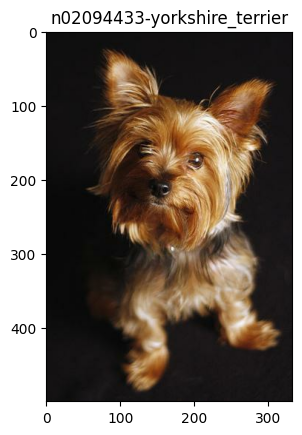

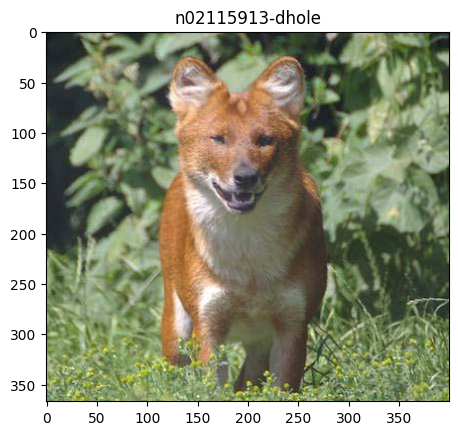

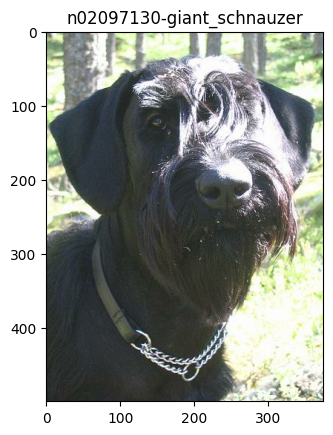

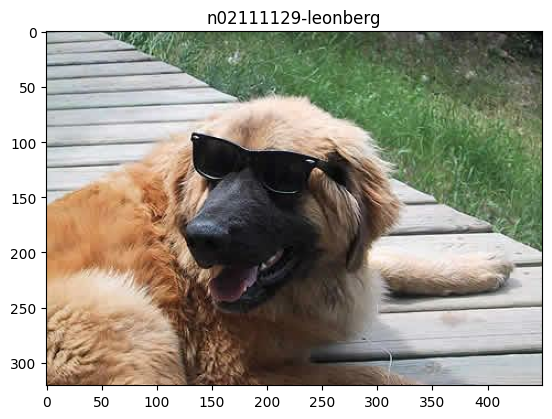

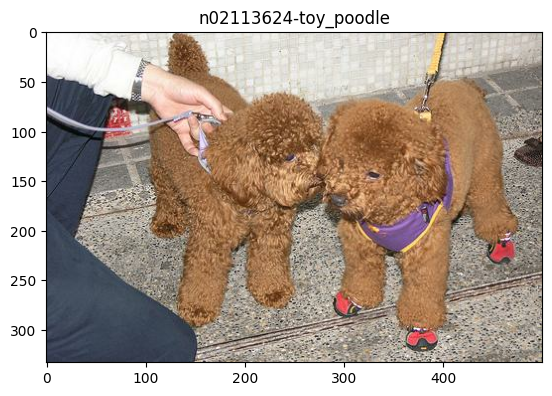

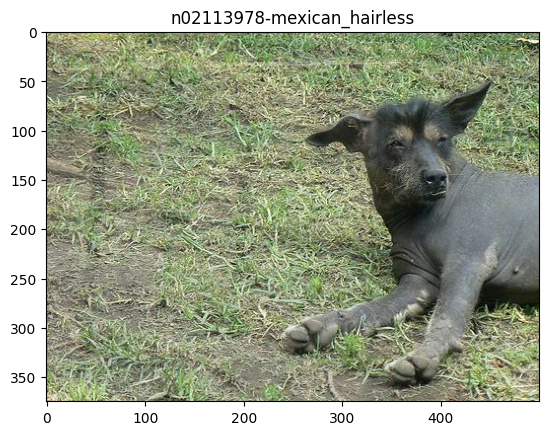

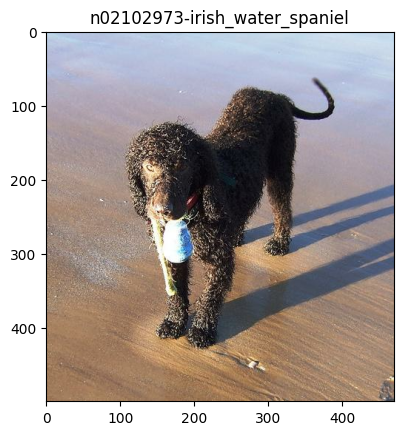

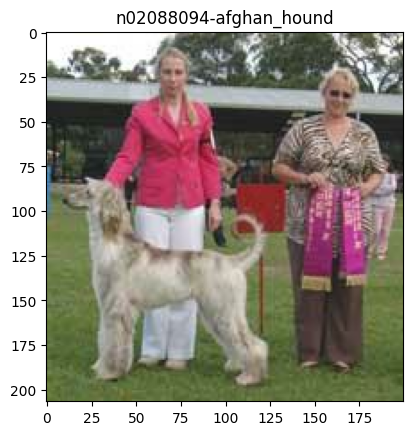

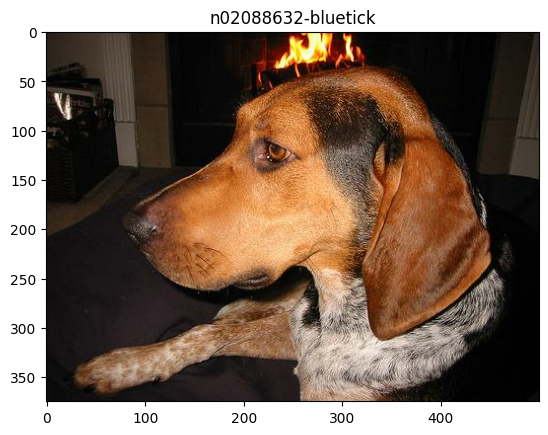

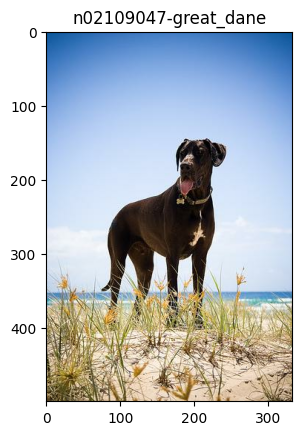

In [2]:
import matplotlib.pyplot as plt

get_name = info.features['label'].int2str

for doggo in dataset['train'].take(10):
    plt.figure()
    plt.imshow(doggo['image'])
    plt.title(get_name(doggo['label']))

# Data Preparation

Here we can see that the dataset is initially split into a training and test set where 12,000 images are specified for training a machine learning model, and the other 8,580 images are for testing the model. 

In [3]:
train_size = info.splits['train'].num_examples
test_size = info.splits['test'].num_examples
print("Size of the training set:", train_size)
print("Size of the test set:", test_size)

Size of the training set: 12000
Size of the test set: 8580


I have decided to use some of the testing images as validation images for the model to examine how well the model is learning and fitting the training data. I have set 60% of the testing set as validation images, leaving 3,432 images for testing. 

In [4]:
train_dataset = dataset['train']
test_dataset = dataset['test']
validation_size = int(test_size * 0.6)
validation_dataset = test_dataset.take(validation_size)
test_dataset = test_dataset.skip(validation_size)
test_set_size = test_size - validation_size
print("Size of the training set:", train_size)
print("Size of the validation set:", validation_size)
print("Size of the test set:", test_set_size)

Size of the training set: 12000
Size of the validation set: 5148
Size of the test set: 3432


Below are the 120 different breeds that are labeled in the dataset.

In [5]:
N_BREEDS = info.features["label"].num_classes

In [6]:
info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

In [7]:
info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around the
    world. This dataset has been built using images and annotation from ImageNet for
    the task of fine-grained image categorization. There are 20,580 images, out of
    which 12,000 are used for training and 8580 for testing. Class labels and
    bounding box annotations are provided for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='/root/tensorflow_datasets/stanford_dogs/0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
        'objects': Sequence({
            'bbox': 

Here I am resizing the images for the machine learning model as well as performing shuffling, batching, and prefetching. 

In [8]:
import tensorflow as tf

IMG_LEN = 224
IMG_SHAPE = (IMG_LEN,IMG_LEN,3)
N_BREEDS = info.features["label"].num_classes

def preprocess(ds_row):
  
    # Image conversion int->float + resizing
    image = tf.image.convert_image_dtype(ds_row['image'], dtype=tf.float32)
    image = tf.image.resize(image, (IMG_LEN, IMG_LEN), method='nearest')
  
    # Onehot encoding labels
    label = tf.one_hot(ds_row['label'],N_BREEDS)

    return image, label

def prepare(dataset, batch_size=None):
    ds = dataset.map(preprocess, num_parallel_calls=4)
    ds = ds.shuffle(buffer_size=1000)
    if batch_size:
      ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
train_batches = prepare(train_dataset, batch_size=32)
validation_batches = prepare(validation_dataset, batch_size=32)
test_batches = prepare(test_dataset, batch_size=32)

# Implementing a Machine Learning Model

For this solution, I will be implementing transfer learning, and I will be trying three different deep neural networking models using the Sequential API in TensorFlow Keras.

The three different models I will be implementing will be the MobileNetV2 model, the InceptionV3 model, and the ResNet101V2 model. 
The MobileNetV2 model will have solid accuracy and excellent efficiency. The InceptionV3 model will have better accuracy but slightly less efficiency than the MobileNetV2 model. Lastly, the ResNet101V2 model ideally would have the most accurate results, but the worst efficiency out of the three models. 

## MobileNetV2 Model

In [10]:
import tensorflow as tf

base_mobile = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [12]:
base_mobile.trainable = False

mobile_model = tf.keras.Sequential([
  base_mobile,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(N_BREEDS, activation='softmax')
])

## InceptionV3 Model

In [13]:
from keras.applications import inception_v3

base_inception = inception_v3.InceptionV3(input_shape=IMG_SHAPE,
                                                weights='imagenet',
                                                include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [14]:
base_inception.trainable = False

inception_model = tf.keras.Sequential([
  base_inception,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(N_BREEDS, activation='softmax')
])

## ResNet101V2 Model

In [15]:
from keras.applications.resnet_v2 import ResNet101V2

base_resnet = ResNet101V2(input_shape=IMG_SHAPE, 
                          weights='imagenet', 
                          include_top=False)

171317808/171317808 [==============================] - 1s 0us/step


In [16]:
base_resnet.trainable = False

resnet_model = tf.keras.Sequential([
  base_resnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(N_BREEDS, activation='softmax')
])

## MobileNetV2 Model Training Results

In [17]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adamax(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])
			  
mobile_history = mobile_model.fit(train_batches,
                    epochs=50,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/50
375/375 [==============================] - 75s 163ms/step - loss: 4.5958 - accuracy: 0.0408 - top_k_categorical_accuracy: 0.1496 - val_loss: 4.2623 - val_accuracy: 0.0828 - val_top_k_categorical_accuracy: 0.2570
Epoch 2/50
375/375 [==============================] - 66s 165ms/step - loss: 4.0337 - accuracy: 0.1194 - top_k_categorical_accuracy: 0.3561 - val_loss: 3.8214 - val_accuracy: 0.1797 - val_top_k_categorical_accuracy: 0.4522
Epoch 3/50
375/375 [==============================] - 64s 160ms/step - loss: 3.6107 - accuracy: 0.2240 - top_k_categorical_accuracy: 0.5441 - val_loss: 3.4426 - val_accuracy: 0.2776 - val_top_k_categorical_accuracy: 0.6210
Epoch 4/50
375/375 [==============================] - 66s 167ms/step - loss: 3.2443 - accuracy: 0.3254 - top_k_categorical_accuracy: 0.6920 - val_loss: 3.1141 - val_accuracy: 0.3669 - val_top_k_categorical_accuracy: 0.7284
Epoch 5/50
375/375 [==============================] - 64s 163ms/step - loss: 2.9251 - accuracy: 0.4166 - top

## InceptionV3 Model Training Results

In [18]:
inception_model.compile(optimizer=tf.keras.optimizers.Adamax(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])
			  
inception_history = inception_model.fit(train_batches,
                    epochs=50,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/50
375/375 [==============================] - 74s 174ms/step - loss: 4.1550 - accuracy: 0.1273 - top_k_categorical_accuracy: 0.3255 - val_loss: 3.4711 - val_accuracy: 0.2836 - val_top_k_categorical_accuracy: 0.6146
Epoch 2/50
375/375 [==============================] - 67s 168ms/step - loss: 2.9698 - accuracy: 0.4309 - top_k_categorical_accuracy: 0.7732 - val_loss: 2.5612 - val_accuracy: 0.5458 - val_top_k_categorical_accuracy: 0.8654
Epoch 3/50
375/375 [==============================] - 65s 166ms/step - loss: 2.1789 - accuracy: 0.6323 - top_k_categorical_accuracy: 0.9128 - val_loss: 1.9223 - val_accuracy: 0.6731 - val_top_k_categorical_accuracy: 0.9283
Epoch 4/50
375/375 [==============================] - 69s 177ms/step - loss: 1.6446 - accuracy: 0.7147 - top_k_categorical_accuracy: 0.9480 - val_loss: 1.5117 - val_accuracy: 0.7261 - val_top_k_categorical_accuracy: 0.9476
Epoch 5/50
375/375 [==============================] - 66s 169ms/step - loss: 1.3063 - accuracy: 0.7533 - top

## ResNet101V2 Model Training Results

In [19]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adamax(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])
			  
resnet_history = resnet_model.fit(train_batches,
                    epochs=50,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/50
375/375 [==============================] - 106s 256ms/step - loss: 4.9265 - accuracy: 0.0288 - top_k_categorical_accuracy: 0.1157 - val_loss: 4.3527 - val_accuracy: 0.0620 - val_top_k_categorical_accuracy: 0.2067
Epoch 2/50
375/375 [==============================] - 95s 247ms/step - loss: 3.8743 - accuracy: 0.1252 - top_k_categorical_accuracy: 0.3466 - val_loss: 3.5592 - val_accuracy: 0.1764 - val_top_k_categorical_accuracy: 0.4571
Epoch 3/50
375/375 [==============================] - 94s 244ms/step - loss: 3.1593 - accuracy: 0.2573 - top_k_categorical_accuracy: 0.5906 - val_loss: 2.9565 - val_accuracy: 0.3011 - val_top_k_categorical_accuracy: 0.6467
Epoch 4/50
375/375 [==============================] - 108s 280ms/step - loss: 2.6165 - accuracy: 0.3821 - top_k_categorical_accuracy: 0.7482 - val_loss: 2.5054 - val_accuracy: 0.3980 - val_top_k_categorical_accuracy: 0.7690
Epoch 5/50
375/375 [==============================] - 95s 245ms/step - loss: 2.2089 - accuracy: 0.4782 - t

## Individual Model Evaluations

In [20]:
print("MobileNetV2 Model: ")
mobile_model.evaluate(test_batches)
print("InceptionV3 Model: ")
inception_model.evaluate(test_batches)
print("ResNet101V2 Model: ")
resnet_model.evaluate(test_batches)

MobileNetV2 Model: 
108/108 [==============================] - 18s 95ms/step - loss: 0.8583 - accuracy: 0.7590 - top_k_categorical_accuracy: 0.9566
InceptionV3 Model: 
108/108 [==============================] - 19s 117ms/step - loss: 0.6352 - accuracy: 0.8094 - top_k_categorical_accuracy: 0.9697
ResNet101V2 Model: 
108/108 [==============================] - 26s 177ms/step - loss: 0.7852 - accuracy: 0.7660 - top_k_categorical_accuracy: 0.9583


[0.7852000594139099, 0.7660256624221802, 0.9583333134651184]

## Inception Model Learning Graphs

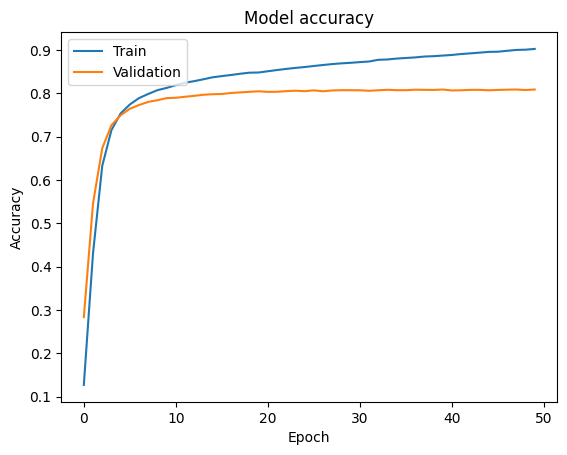

In [21]:
plt.plot(inception_history.history['accuracy'])
plt.plot(inception_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

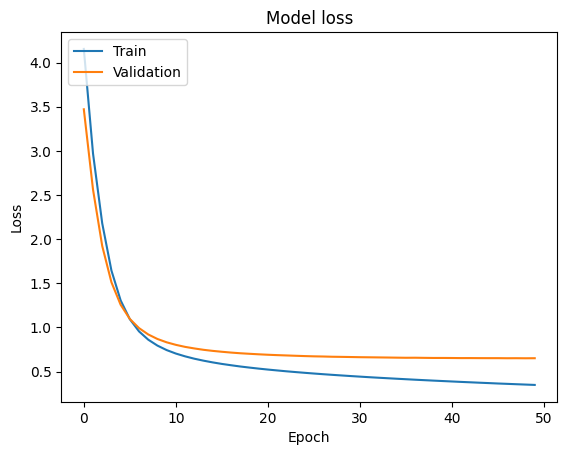

In [22]:
plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Custom Image Predicting

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

sadie_img = load_img('sadie.jpg', target_size=(224, 224))
sadie_array = img_to_array(sadie_img)
sadie_array = (sadie_array - 127.5) / 127.5
sadie_array = np.expand_dims(sadie_array, axis=0)

In [24]:
prediction = inception_model.predict(sadie_array)
predicted_class_index = np.argmax(prediction)
predicted_classes = np.argsort(-prediction[0])[:5]
predicted_scores = prediction[0][predicted_classes]
print("Predicted class:", predicted_class_index)
print("Confidence score:", prediction[0][predicted_class_index])

1/1 [==============================] - 2s 2s/step
Predicted class: 117
Confidence score: 0.5767947


In [25]:
get_name = info.features['label'].int2str
print(get_name(117))

n02115641-dingo


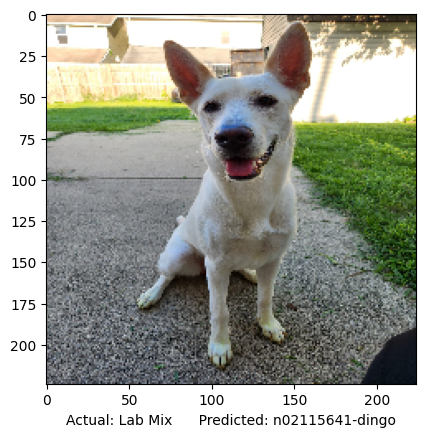

<Figure size 200x200 with 0 Axes>

In [26]:
plt.xlabel("Actual: Lab Mix" + "      Predicted: " + get_name(117))
plt.imshow(sadie_img)
plt.figure(figsize=(2, 2))
plt.show()

Examples of a White Dingo from google.com


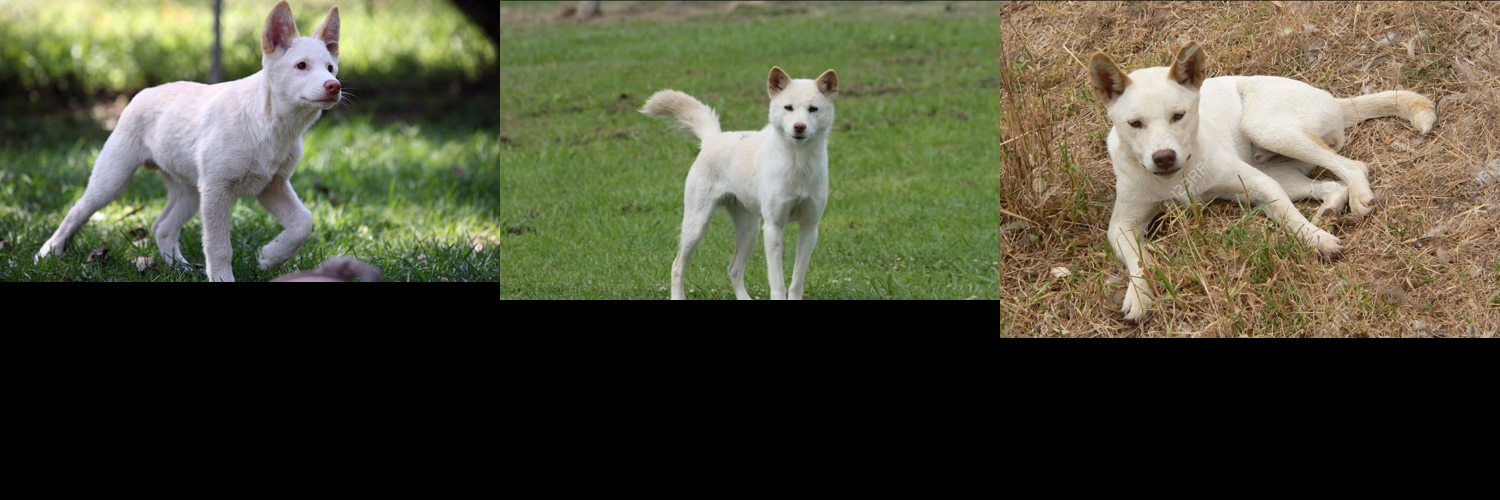

In [27]:
from PIL import Image, ImageOps

image1 = Image.open('dingo_one.jpg')
image2 = Image.open('dingo_two.jpg')
image3 = Image.open('dingo_three.jpg')
new_size = 500
image1.thumbnail((new_size, new_size))
image2.thumbnail((new_size, new_size))
image3.thumbnail((new_size, new_size))
total_width = image1.width + image2.width + image3.width
new_image = Image.new('RGB', (total_width, new_size))
new_image.paste(image1, (0, 0))
new_image.paste(image2, (image1.width, 0))
new_image.paste(image3, (image1.width + image2.width, 0))

print("Examples of a White Dingo from google.com")
new_image.show()

In [28]:
print("Top 5 predicted classes:")
for i in range(5):
    print("Class:", predicted_classes[i], "Confidence score:", predicted_scores[i])

Top 5 predicted classes:
Class: 117 Confidence score: 0.5767947
Class: 76 Confidence score: 0.36992693
Class: 29 Confidence score: 0.010677339
Class: 101 Confidence score: 0.009100699
Class: 0 Confidence score: 0.008139117


In [29]:
print(get_name(117), "\t\tConfidence score:", predicted_scores[0])
print(get_name(76), "\t\tConfidence score:", predicted_scores[1])
print(get_name(74), "\t\tConfidence score:", predicted_scores[2])
print(get_name(0), "\t\tConfidence score:", predicted_scores[3])
print(get_name(101), "\t\tConfidence score:", predicted_scores[4])

n02115641-dingo 		Confidence score: 0.5767947
n02105412-kelpie 		Confidence score: 0.36992693
n02105162-malinois 		Confidence score: 0.010677339
n02085620-chihuahua 		Confidence score: 0.009100699
n02110806-basenji 		Confidence score: 0.008139117


In [30]:
bailey_img = load_img('bailey.jpg', target_size=(224, 224))
bailey_array = img_to_array(bailey_img)
bailey_array = (bailey_array - 127.5) / 127.5
bailey_array = np.expand_dims(bailey_array, axis=0)

prediction = inception_model.predict(bailey_array)
predicted_class_index = np.argmax(prediction)
predicted_classes = np.argsort(-prediction[0])[:5]
predicted_scores = prediction[0][predicted_classes]

print("Predicted class:", predicted_class_index)
print("Confidence score:", prediction[0][predicted_class_index])

1/1 [==============================] - 0s 49ms/step
Predicted class: 79
Confidence score: 0.24554175


In [31]:
print(get_name(67))

n02102177-welsh_springer_spaniel


In [32]:
print("Top 5 predicted classes:")
for i in range(5):
    print("Class:", predicted_classes[i], "Confidence score:", predicted_scores[i])

Top 5 predicted classes:
Class: 79 Confidence score: 0.24554175
Class: 67 Confidence score: 0.17677595
Class: 5 Confidence score: 0.1625339
Class: 64 Confidence score: 0.13231169
Class: 80 Confidence score: 0.03653904


In [33]:
print(get_name(67), "\tConfidence score:", predicted_scores[0])
print(get_name(64), "\t\tConfidence score:", predicted_scores[1])
print(get_name(79), "\t\tConfidence score:", predicted_scores[2])
print(get_name(80), "\t\t\tConfidence score:", predicted_scores[3])
print(get_name(5), "\t\tConfidence score:", predicted_scores[4])

n02102177-welsh_springer_spaniel 	Confidence score: 0.24554175
n02101388-brittany_spaniel 		Confidence score: 0.17677595
n02105855-shetland_sheepdog 		Confidence score: 0.1625339
n02106030-collie 			Confidence score: 0.13231169
n02086646-blenheim_spaniel 		Confidence score: 0.03653904


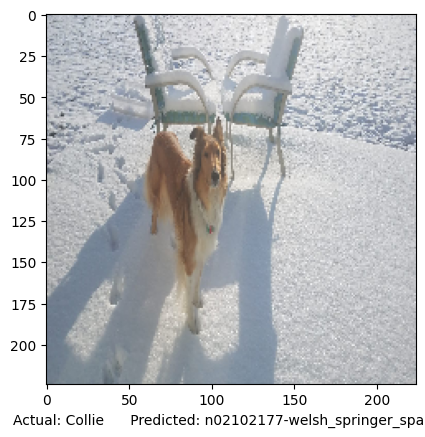

<Figure size 200x300 with 0 Axes>

In [34]:
plt.xlabel("Actual: Collie" + "      Predicted: " + get_name(67))
plt.imshow(bailey_img)
plt.figure(figsize=(2, 3))
plt.show()

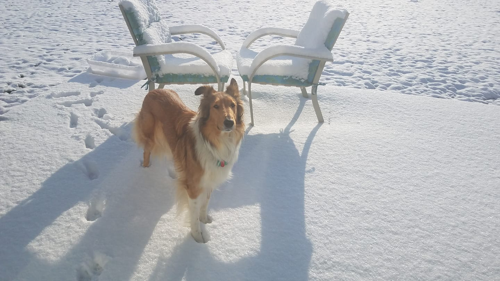

In [35]:
from PIL import Image
image = Image.open('bailey.jpg')
new_size = 500
image.thumbnail((new_size, new_size))
image.show()

In [36]:
blizzard_img = load_img('blizzard.jpg', target_size=(224, 224))
blizzard_array = img_to_array(blizzard_img)
blizzard_array = (blizzard_array - 127.5) / 127.5
blizzard_array = np.expand_dims(blizzard_array, axis=0)

prediction = inception_model.predict(blizzard_array)
predicted_class_index = np.argmax(prediction)
predicted_classes = np.argsort(-prediction[0])[:5]
predicted_scores = prediction[0][predicted_classes]

print("Predicted class:", predicted_class_index)
print("Confidence score:", prediction[0][predicted_class_index])

1/1 [==============================] - 0s 28ms/step
Predicted class: 106
Confidence score: 0.65938365


In [37]:
print("Top 5 predicted classes:")
for i in range(5):
    print("Class:", predicted_classes[i], "Confidence score:", predicted_scores[i])

Top 5 predicted classes:
Class: 106 Confidence score: 0.65938365
Class: 107 Confidence score: 0.26248342
Class: 108 Confidence score: 0.036639426
Class: 99 Confidence score: 0.0064835274
Class: 109 Confidence score: 0.0048742993


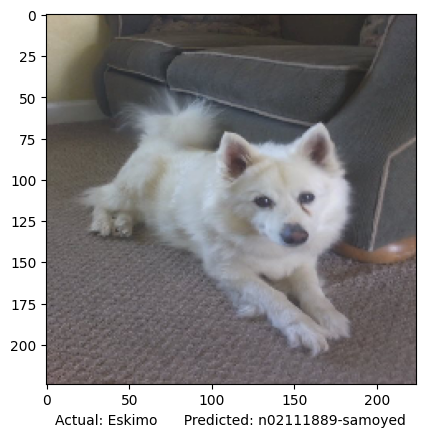

<Figure size 200x300 with 0 Axes>

In [39]:
plt.xlabel("Actual: Eskimo" + "      Predicted: " + get_name(106))
plt.imshow(blizzard_img)
plt.figure(figsize=(2, 3))
plt.show()

In [43]:
print(get_name(106), "\t\tConfidence score:", predicted_scores[0])
print(get_name(107), "\t\tConfidence score:", predicted_scores[1])
print(get_name(108), "\t\t\tConfidence score:", predicted_scores[2])
print(get_name(99), "\tConfidence score:", predicted_scores[3])
print(get_name(109), "\t\tConfidence score:", predicted_scores[4])

n02111889-samoyed 		Confidence score: 0.65938365
n02112018-pomeranian 		Confidence score: 0.26248342
n02112137-chow 			Confidence score: 0.036639426
n02110185-siberian_husky 	Confidence score: 0.0064835274
n02112350-keeshond 		Confidence score: 0.0048742993


In [44]:
bazooka_img = load_img('bazooka.jpg', target_size=(224, 224))
bazooka_array = img_to_array(bazooka_img)
bazooka_array = (bazooka_array - 127.5) / 127.5
bazooka_array = np.expand_dims(bazooka_array, axis=0)

prediction = inception_model.predict(bazooka_array)
predicted_class_index = np.argmax(prediction)
predicted_classes = np.argsort(-prediction[0])[:5]
predicted_scores = prediction[0][predicted_classes]

print("Predicted class:", predicted_class_index)
print("Confidence score:", prediction[0][predicted_class_index])

1/1 [==============================] - 0s 27ms/step
Predicted class: 108
Confidence score: 0.99713683


In [45]:
print("Top 5 predicted classes:")
for i in range(5):
    print("Class:", predicted_classes[i], "Confidence score:", predicted_scores[i])

Top 5 predicted classes:
Class: 108 Confidence score: 0.99713683
Class: 93 Confidence score: 0.0010898409
Class: 107 Confidence score: 0.0002974948
Class: 56 Confidence score: 0.00022058444
Class: 109 Confidence score: 0.00012081566


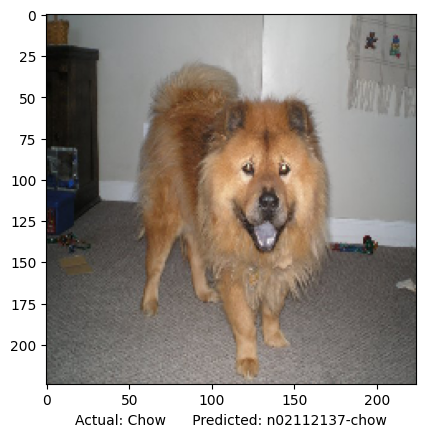

<Figure size 200x300 with 0 Axes>

In [46]:
plt.xlabel("Actual: Chow" + "      Predicted: " + get_name(108))
plt.imshow(bazooka_img)
plt.figure(figsize=(2, 3))
plt.show()

In [48]:
print(get_name(108), "\t\t\t\tConfidence score:", predicted_scores[0])
print(get_name(93), "\t\tConfidence score:", predicted_scores[1])
print(get_name(107), "\t\t\tConfidence score:", predicted_scores[2])
print(get_name(56), "\t\tConfidence score:", predicted_scores[3])
print(get_name(109), "\t\t\tConfidence score:", predicted_scores[4])

n02112137-chow 				Confidence score: 0.99713683
n02108551-tibetan_mastiff 		Confidence score: 0.0010898409
n02112018-pomeranian 			Confidence score: 0.0002974948
n02099601-golden_retriever 		Confidence score: 0.00022058444
n02112350-keeshond 			Confidence score: 0.00012081566


# Conclusion

In [49]:
inception_model.save('my_inception_model.h5')